In [23]:
from pathlib import Path
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
main_path = Path.cwd()
netcdf_path = main_path.joinpath('adaptor.cams_regional_fc.retrieve-1704441246.9534526-29460-11-5d3bb664-261d-4612-a637-a64b63cffaeb.nc')
boundaries_path = main_path.joinpath('Reg01012023_g').joinpath('Reg01012023_g_WGS84.shp')

(True, True)

In [4]:
netcdf_data = xr.open_dataset(netcdf_path)

netcdf_data

<xarray.Dataset>
Dimensions:    (longitude: 125, latitude: 124, level: 3, time: 48)
Coordinates:
  * longitude  (longitude) float32 6.35 6.45 6.55 6.65 ... 18.55 18.65 18.75
  * latitude   (latitude) float32 47.25 47.15 47.05 46.95 ... 35.15 35.05 34.95
  * level      (level) float32 0.0 50.0 100.0
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 23:00:00
Data variables:
    pm10_conc  (time, level, latitude, longitude) float32 ...
    so2_conc   (time, level, latitude, longitude) float32 ...
Attributes:
    title:        PM10/SO2 Air Pollutant ANALYSIS at 3 levels
    institution:  Data produced by ENEA (Italy)
    source:       Data from MINNI model
    history:      Model MINNI ANALYSIS
    ANALYSIS:     Europe, 20231231-20240101+[0H_23H]
    summary:      MINNI model hourly ANALYSIS of PM10/SO2 concentration at 3 ...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [22]:
single_data = netcdf_data[dict(level=[0], time=[0])]
single_data = single_data['pm10_conc']

single_data

<xarray.DataArray 'pm10_conc' (time: 1, level: 1, latitude: 124, longitude: 125)>
array([[[[ 6.28404 , ..., 42.400173],
         ...,
         [ 3.482327, ...,  5.481837]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 6.35 6.45 6.55 6.65 ... 18.55 18.65 18.75
  * latitude   (latitude) float32 47.25 47.15 47.05 46.95 ... 35.15 35.05 34.95
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 00:00:00
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

In [20]:
boundaries_data = gpd.read_file(boundaries_path).to_crs('EPSG:4326')

boundaries_data

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry
0,1,1,Piemonte,1.236800e+06,2.539388e+10,"POLYGON ((8.44976 46.46176, 8.46176 46.45081, ..."
1,1,2,Valle d'Aosta,3.109681e+05,3.258838e+09,"POLYGON ((7.58857 45.97075, 7.58981 45.97073, ..."
2,1,3,Lombardia,1.410223e+06,2.386232e+10,"MULTIPOLYGON (((8.81642 45.02231, 8.81427 45.0..."
3,2,4,Trentino-Alto Adige,8.008937e+05,1.360755e+10,"POLYGON ((12.20511 47.08653, 12.20668 47.08627..."
4,2,5,Veneto,1.054587e+06,1.834355e+10,"POLYGON ((12.50591 46.67839, 12.50603 46.67803..."
5,2,6,Friuli Venezia Giulia,6.708207e+05,7.934116e+09,"MULTIPOLYGON (((13.77538 45.61068, 13.77538 45..."
6,1,7,Liguria,8.196598e+05,5.414542e+09,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0..."
7,2,8,Emilia-Romagna,1.180343e+06,2.249987e+10,"MULTIPOLYGON (((10.48080 44.18949, 10.48069 44..."
8,3,9,Toscana,1.306243e+06,2.298404e+10,"MULTIPOLYGON (((11.11471 42.25911, 11.11625 42..."
9,3,10,Umbria,6.197684e+05,8.464380e+09,"MULTIPOLYGON (((12.43119 43.59136, 12.43030 43..."


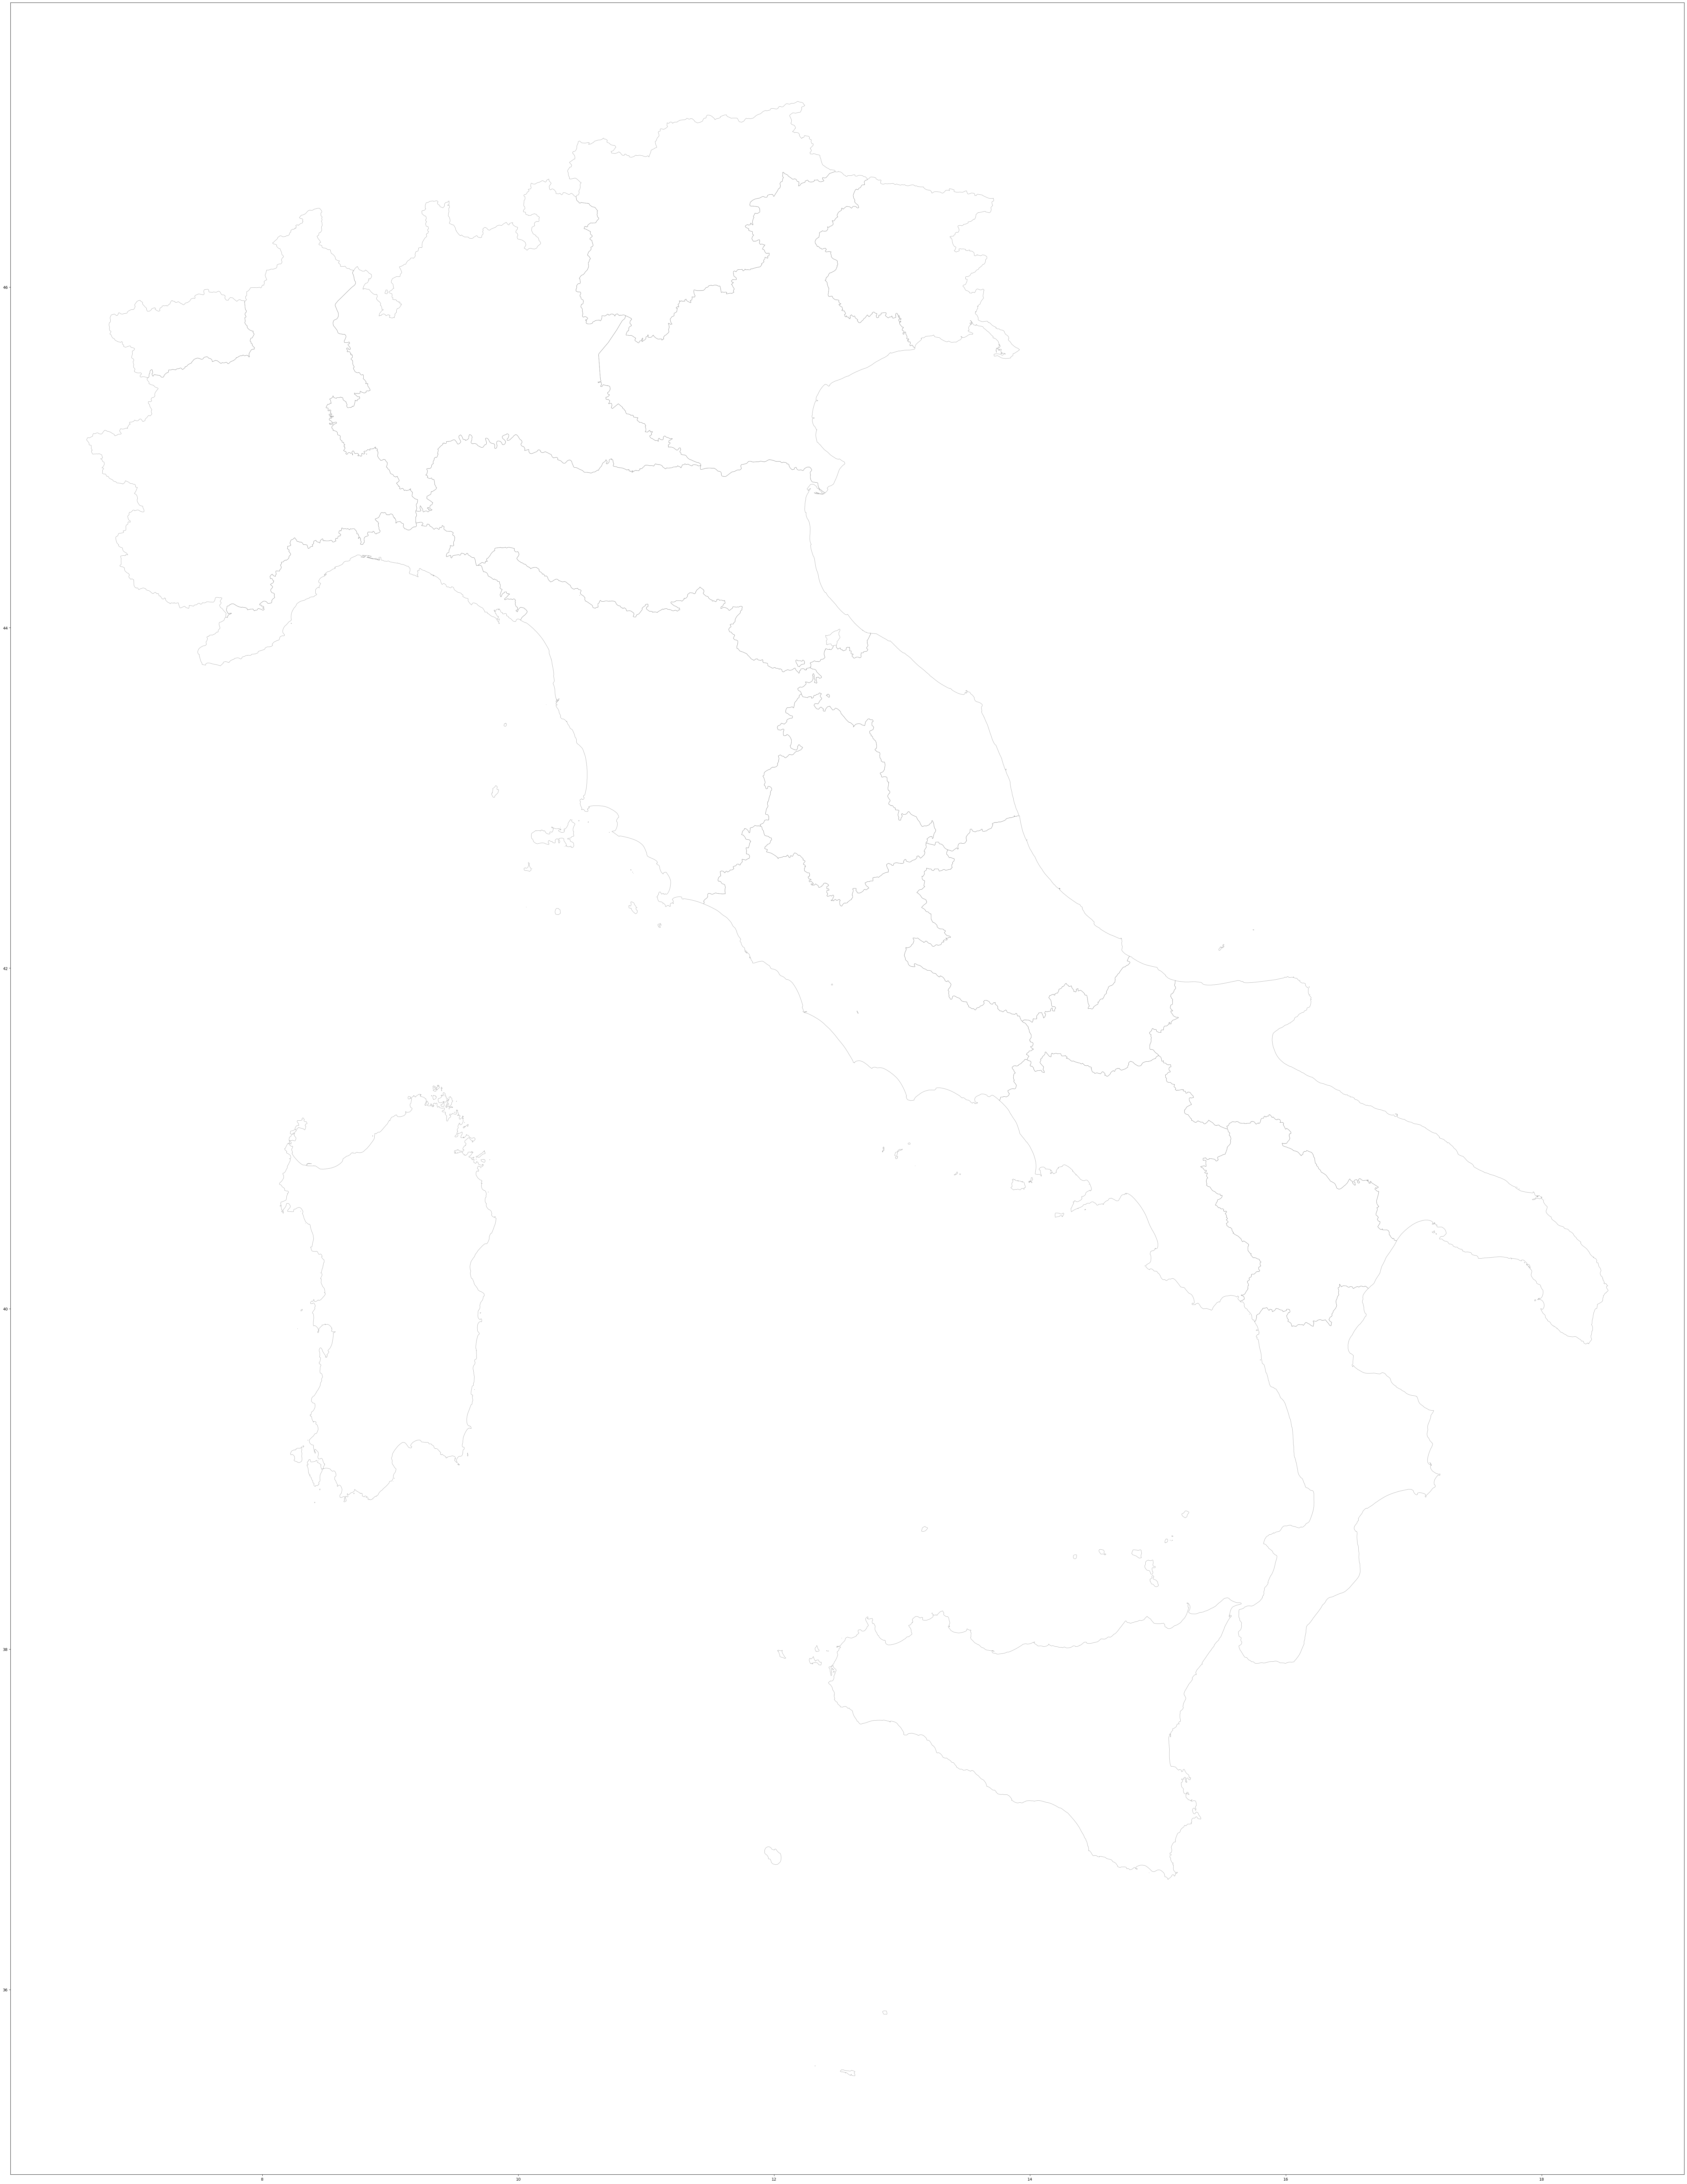

In [25]:
fig, ax = plt.subplots(figsize=(100, 100))

boundaries_data.boundary.plot(
    ax=ax,
    edgecolor='grey',
    linewidth=0.5
)

plt.show()